In [ ]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
from datetime import datetime
from functools import reduce
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Path to the data folder
data_folder = '/content/drive/MyDrive/Capstone Data/Final Data'
if not os.path.exists(data_folder):
    raise FileNotFoundError(f"Data folder not found: {data_folder}. Contents: {os.listdir('/content/drive/MyDrive')}")
print(f"Files in {data_folder}: {os.listdir(data_folder)}")

files = [
    'Annual Labor Force Survey.csv',
    'clean_import_of_goods_and_services_as_a_percentage_of_GDP (1).csv',
    'clean_inflation_rate (2).csv',
    'clean_labor_force_participation_rate_modeled.csv',
    'Cleaned_GDP_Per_Capita_Data_2010_2023 - Cleaned_GDP_Per_Capita_Data_2010_2023.csv',
    'export_of_goods_and_services___GDP (1).csv',
    'Filtered_FDI_2010_2023.csv',
    'filtered_gdp_usd (1).csv',
    'Filtered_Real_Interest_Rates_Final.csv',
    'Filtered_Unemployment_Rate.csv',
    'population_growth_cleaned.csv',
    'tax_to_gdp_2009_2023.csv',
    'filtered_corruption_score(0-100).csv',
    'Average Wage Data  - Average Wage Data .csv'
]
target_file = 'Public_Sector_Debt.csv'

# Corrected rename_dict
rename_dict = {
    'Annual Labor Force Survey': 'Labor_Force_Survey',
    'clean_import_of_goods_and_services_as_a_percentage_of_GDP (1)': 'Imports_to_GDP',
    'clean_inflation_rate (2)': 'Inflation_Rate',
    'clean_labor_force_participation_rate_modeled': 'Labor_Force_Participation',
    'Cleaned_GDP_Per_Capita_Data_2010_2023 - Cleaned_GDP_Per_Capita_Data_2010_2023': 'GDP_Per_Capita',
    'export_of_goods_and_services___GDP (1)': 'Exports_to_GDP',
    'Filtered_FDI_2010_2023': 'FDI',
    'filtered_gdp_usd (1)': 'GDP_USD',
    'Filtered_Real_Interest_Rates_Final': 'Real_Interest_Rates',
    'Filtered_Unemployment_Rate': 'Unemployment_Rate',
    'population_growth_cleaned': 'Population_Growth',
    'tax_to_gdp_2009_2023': 'Tax_to_GDP',
    'filtered_corruption_score(0-100)': 'Corruption',
    'Average Wage Data  - Average Wage Data ': 'Wage'
}

Files in /content/drive/MyDrive/Capstone Data/Final Data: ['tax_to_gdp_2009_2023.csv', 'population_growth_cleaned.csv', 'Filtered_Unemployment_Rate.csv', 'Filtered_Real_Interest_Rates_Final.csv', 'Filtered_FDI_2010_2023.csv', 'export_of_goods_and_services___GDP (1).csv', 'Cleaned_GDP_Per_Capita_Data_2010_2023 - Cleaned_GDP_Per_Capita_Data_2010_2023.csv', 'clean_labor_force_participation_rate_modeled.csv', 'clean_inflation_rate (2).csv', 'clean_import_of_goods_and_services_as_a_percentage_of_GDP (1).csv', 'Annual Labor Force Survey.csv', 'Tax_Revenue_2010_2023_updated - Tax_Revenue_2010_2023_updated.csv', 'filtered_urban_population(% of total polpulation) - filtered_urban_population(% of total polpulation).csv', 'Average Wage Data  - Average Wage Data .csv', 'filtered_gdp_usd (1).csv', 'WUI_Annual_Averages_2009_2023_Pivot (1).gsheet', 'CPI.csv', 'filtered_corruption_score(0-100).csv', '.ipynb_checkpoints', 'Public_Sector_Debt.csv', 'rf_results_importances_vif.csv', 'debt_risk_scores_box

In [ ]:
# Function to load and preprocess data
def load_and_preprocess(file_path):
    try:
        df = pd.read_csv(os.path.join(data_folder, file_path))
        df['CCode'] = df['CCode'].astype(str)
        year_cols = [col for col in df.columns if col not in ['CCode', 'Country', 'Country Name'] and col.isdigit()]
        df_melt = pd.melt(df, id_vars=['CCode'], value_vars=year_cols,
                          var_name='Year', value_name=file_path.split('.')[0])
        df_melt['Year'] = df_melt['Year'].astype(int)
        value_col = file_path.split('.')[0]
        if df_melt[value_col].dtype not in ['float64', 'int64']:
            df_melt[value_col] = pd.to_numeric(df_melt[value_col].astype(str).str.replace(',', ''), errors='coerce')
        if value_col in rename_dict:
            df_melt = df_melt.rename(columns={value_col: rename_dict[value_col]})
        return df_melt
    except Exception as e:
        print(f"Error processing {file_path}: {type(e).__name__} - {str(e)}")
        return None

# Load target variable
target_df = load_and_preprocess(target_file)
if target_df is None:
    raise ValueError("Failed to load target file")
target_df = target_df.rename(columns={target_file.split('.')[0]: 'Public_Sector_Debt'})

# Load all predictor datasets
predictor_dfs = []
for file in files:
    df = load_and_preprocess(file)
    if df is not None:
        predictor_dfs.append(df)
    else:
        print(f"Skipping {file} due to loading error")

# Merge all datasets
merged_df = reduce(lambda left, right: pd.merge(left, right, on=['CCode', 'Year'], how='inner'), [target_df] + predictor_dfs)

# Check missing values
print("Missing values before processing:")
print(merged_df.isna().sum())
initial_rows = merged_df.shape[0]
merged_df = merged_df.fillna(merged_df.mean(numeric_only=True))
print(f"Shape of merged dataset after imputation: {merged_df.shape}")
print(f"Rows retained: {merged_df.shape[0]} ({(merged_df.shape[0] / initial_rows) * 100:.2f}%)")

Missing values before processing:
CCode                        0
Year                         0
Public_Sector_Debt           0
Labor_Force_Survey           0
Imports_to_GDP               0
Inflation_Rate               0
Labor_Force_Participation    0
GDP_Per_Capita               0
Exports_to_GDP               0
FDI                          0
GDP_USD                      0
Real_Interest_Rates          0
Unemployment_Rate            0
Population_Growth            0
Tax_to_GDP                   0
Corruption                   0
Wage                         0
dtype: int64
Shape of merged dataset after imputation: (518, 17)
Rows retained: 518 (100.00%)


In [ ]:
def run_feature_analysis_by_country(country_code, merged_df, all_predictors):
    print(f"\n--- Running model for {country_code} ---")

    # Filter for the specified country
    analysis_df = merged_df[merged_df['CCode'] == country_code].copy()

    # Add dummies
    analysis_df['COVID_Dummy'] = analysis_df['Year'].apply(lambda x: 1 if x in [2020, 2021] else 0)
    analysis_df['Eurozone_Crisis_Dummy'] = analysis_df['Year'].apply(lambda x: 1 if x in [2010, 2011] else 0)

    # Start with all features + dummies
    features = all_predictors + ['COVID_Dummy', 'Eurozone_Crisis_Dummy']
    X = analysis_df[features].apply(pd.to_numeric, errors='coerce').select_dtypes(include=['float64', 'int64'])
    y = np.log1p(analysis_df['Public_Sector_Debt'])

    # Drop features with too many missing values
    X = X.dropna(axis=1, thresh=int(0.8 * len(X)))

    # Drop rows with any remaining NaNs
    X = X.dropna()
    y = y.loc[X.index]

    # Reduce number of predictors if necessary
    if X.shape[0] <= X.shape[1]:
        print(f"Too many predictors ({X.shape[1]}) for {X.shape[0]} observations. Reducing based on variance.")
        X = X.loc[:, X.var().sort_values(ascending=False).head(X.shape[0]-2).index]  # keep max (n-2) predictors

    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = sm.add_constant(X_scaled)

    # Fit model
    model = sm.OLS(y, X_scaled).fit()

    # VIF
    X_vif = sm.add_constant(X)
    vif_data = pd.DataFrame({
        'Variable': X_vif.columns,
        'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    })

    # Collect results
    results = {
        'Variable': ['const'] + X.columns.tolist(),
        'Coefficient': model.params,
        'P-value': model.pvalues
    }
    results_df = pd.DataFrame(results)
    results_df['VIF'] = results_df['Variable'].map(vif_data.set_index('Variable')['VIF'])

    return model.summary(), results_df


Remaining countries: ['AUS', 'AUT', 'BEL', 'CAN', 'CHE', 'DEU', 'DNK', 'FIN', 'FRA', 'GBR', 'IRL', 'ISL', 'JPN', 'LUX', 'NLD', 'NOR', 'NZL', 'SWE', 'USA']
Data shape after outlier removal: (266, 17)

Initial Variance Inflation Factors (VIF):
                 Variable         VIF
0                   const  400.830808
1          Inflation_Rate    1.309731
2      Labor_Force_Survey    7.421939
3          GDP_Per_Capita    2.536103
4       Population_Growth    1.794506
5              Corruption    1.506528
6                    Wage    2.355123
7       Unemployment_Rate    1.635096
8             COVID_Dummy    1.143006
9   Eurozone_Crisis_Dummy    1.346540
10            Country_USA    5.996232

Iteration 1: No insignificant predictors (p > 0.05) to drop. Stopping.

Final Variance Inflation Factors (VIF):
                 Variable         VIF
0                   const  400.830808
1          Inflation_Rate    1.309731
2      Labor_Force_Survey    7.421939
3          GDP_Per_Capita    2.536103

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# --- Calculate RMSE for final model ---
y_pred_log = model_final.predict(sm.add_constant(StandardScaler().fit_transform(X_final)))
rmse_log = np.sqrt(mean_squared_error(y, y_pred_log))
rmse_actual = np.sqrt(mean_squared_error(np.expm1(y), np.expm1(y_pred_log)))  # Back-transformed RMSE

print(f"\nRMSE (on log-transformed scale): {rmse_log:.4f}")
print(f"RMSE (on actual debt scale): {rmse_actual:.2f}")



RMSE (on log-transformed scale): 0.3541
RMSE (on actual debt scale): 25.79


<ipython-input-9-8e62dfdf1c85>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='CCode', y='Mean_Log_Debt', data=mean_debt, palette=colors)


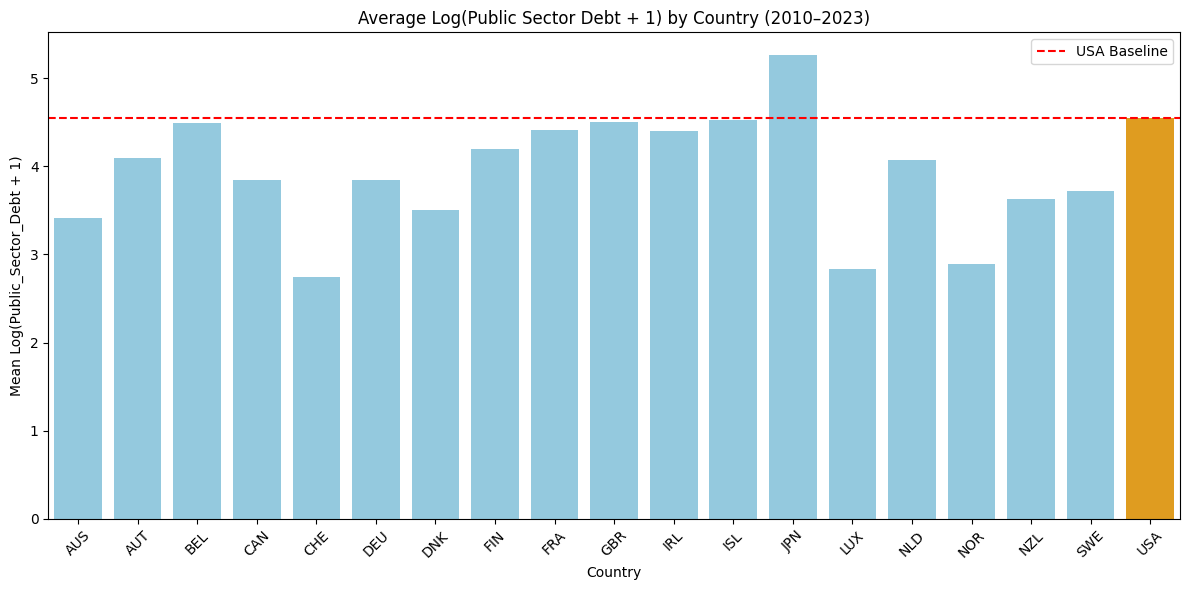

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Ensure data_folder exists
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

# --- Visualization: Bar Plot of Average Log(Public Sector Debt) by Country ---
# Calculate mean log(Public_Sector_Debt + 1) per country
mean_debt = analysis_df.groupby('CCode')['Public_Sector_Debt'].mean().apply(np.log1p).reset_index()
mean_debt = mean_debt.rename(columns={'Public_Sector_Debt': 'Mean_Log_Debt'})

# Create bar plot
plt.figure(figsize=(12, 6))
# Use a different color for USA
colors = ['orange' if ccode == 'USA' else 'skyblue' for ccode in mean_debt['CCode']]
sns.barplot(x='CCode', y='Mean_Log_Debt', data=mean_debt, palette=colors)
plt.axhline(y=mean_debt[mean_debt['CCode'] == 'USA']['Mean_Log_Debt'].values[0], color='red', linestyle='--', label='USA Baseline')
plt.title('Average Log(Public Sector Debt + 1) by Country (2010–2023)')
plt.xlabel('Country')
plt.ylabel('Mean Log(Public_Sector_Debt + 1)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(data_folder, 'public_sector_debt_by_country_vs_usa.png'))
plt.show()

Using exogenous features for ARIMAX: ['Inflation_Rate', 'Labor_Force_Survey', 'GDP_Per_Capita', 'Population_Growth', 'Corruption', 'Wage', 'Unemployment_Rate', 'COVID_Dummy', 'Eurozone_Crisis_Dummy', 'Country_USA']


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn


Forecast results saved to /content/drive/MyDrive/Capstone Data/Final Data/arimax_forecast_results_2030.csv


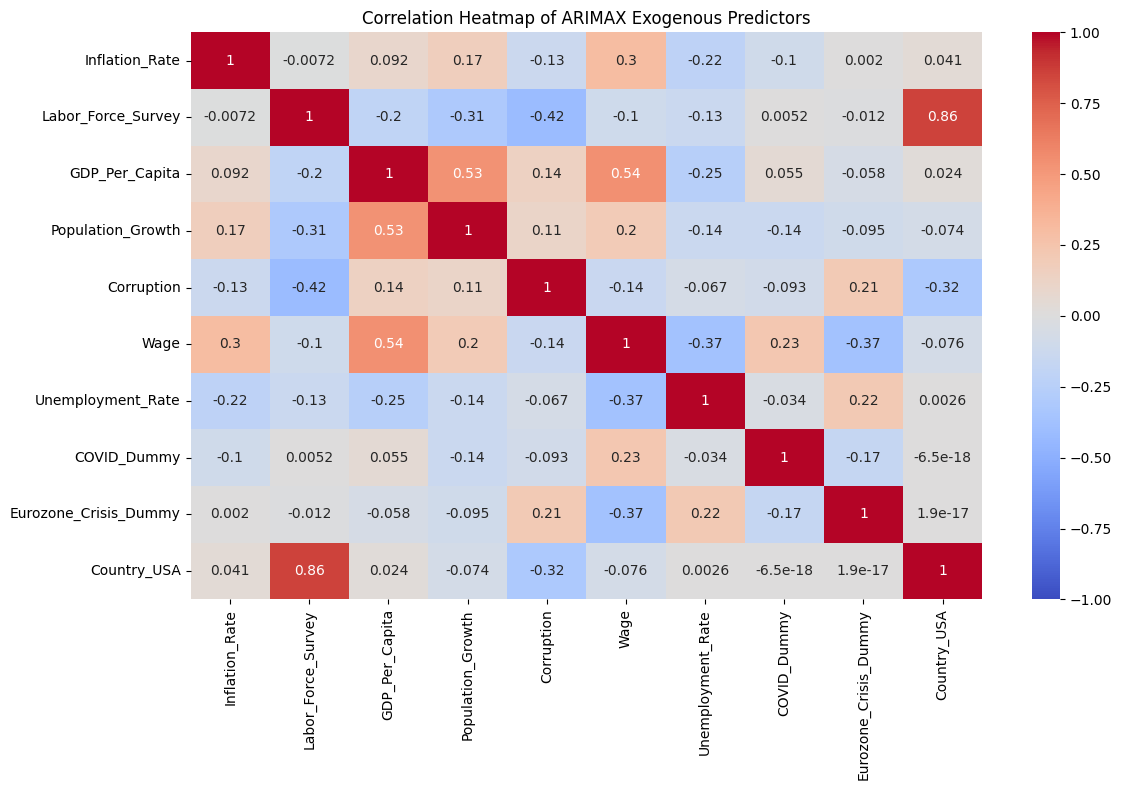

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

#Defines what years were forcasting
#Through 2030
forecast_years = list(range(2024, 2031))
n_forecast = len(forecast_years)
countries = analysis_df['CCode'].unique()

#Use significant predictors from final_features from last step
exog_features = [f for f in final_features]
if not exog_features:
    raise ValueError("No exogenous features available for ARIMAX.")

print(f"Using exogenous features for ARIMAX: {exog_features}")

#Initialize and fit the scalar on historical data of the features
arimax_scaler = StandardScaler()
arimax_scaler.fit(analysis_df[exog_features])

#Create storage for forecast results
forecast_results = []

#Functio to generate new rediction
def prepare_future_exog(last_row, exog_features, n_forecast, scaler, country_df):
    exog_future = np.zeros((n_forecast, len(exog_features)))
    for i, feature in enumerate(exog_features):
        if feature in ['COVID_Dummy', 'Eurozone_Crisis_Dummy']:
            exog_future[:, i] = 0  # No future shocks, assuming covid or a econ. crisis will not happen
        else:
            #Reduces slopes over time, slopes were getting steep and non-realistic
            historical_values = country_df[feature].values
            if len(historical_values) > 1:
                annual_change = (historical_values[-1] - historical_values[0]) / (len(historical_values) - 1)
                t = np.arange(1, n_forecast + 1)
                damping_factor = 1 / (1 + 0.1 * t)
                exog_future[:, i] = last_row[feature] + annual_change * t * damping_factor
            else:
                exog_future[:, i] = last_row[feature]
    exog_future_scaled = scaler.transform(exog_future)
    return exog_future_scaled

#Fit ARIMAX Model by Country
for country in countries:
    try:
        country_df = analysis_df[analysis_df['CCode'] == country].sort_values('Year')
        if country_df.shape[0] < 5:
            print(f"Skipping {country}: insufficient data points ({country_df.shape[0]})")
            continue

        #target variable: Public sector debt
        y_country = country_df['Public_Sector_Debt'].reset_index(drop=True)  # Non-log-transformed
        exog_data = country_df[exog_features].copy()
        exog_scaled = arimax_scaler.transform(exog_data)
        exog_data = exog_scaled
        order = (0, 1, 1)
        try:
            model = ARIMA(y_country, exog=exog_data, order=order)
            results = model.fit()
        except Exception as e:
            print(f"Skipping {country}: ARIMAX model failed - {str(e)}")
            continue

        # Prepare future exogenous data
        last_row = country_df.iloc[-1]
        exog_future = prepare_future_exog(last_row, exog_features, n_forecast, arimax_scaler, country_df)

        # Forecast
        forecast_values = results.forecast(steps=n_forecast, exog=exog_future)

        # Store results
        for year, value in zip(forecast_years, forecast_values):
            forecast_results.append({
                'CCode': country,
                'Year': year,
                'Public_Sector_Debt_Forecast': value
            })

    except Exception as e:
        print(f"Error processing {country}: {str(e)}")
        continue

# Save Forecast Results ---
forecast_df = pd.DataFrame(forecast_results)
forecast_path = os.path.join(data_folder, 'arimax_forecast_results_2030.csv')
forecast_df.to_csv(forecast_path, index=False)
print(f"\nForecast results saved to {forecast_path}")

#Visualizations
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

#Correlation Heatmap
if exog_features:
    plt.figure(figsize=(12, 8))
    corr_matrix = analysis_df[exog_features].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Heatmap of ARIMAX Exogenous Predictors')
    plt.tight_layout()
    plt.show()
else:
    print("Warning: No exogenous features for correlation heatmap.")

<ipython-input-11-59af7ab81953>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette=coef_df['Color'].tolist())


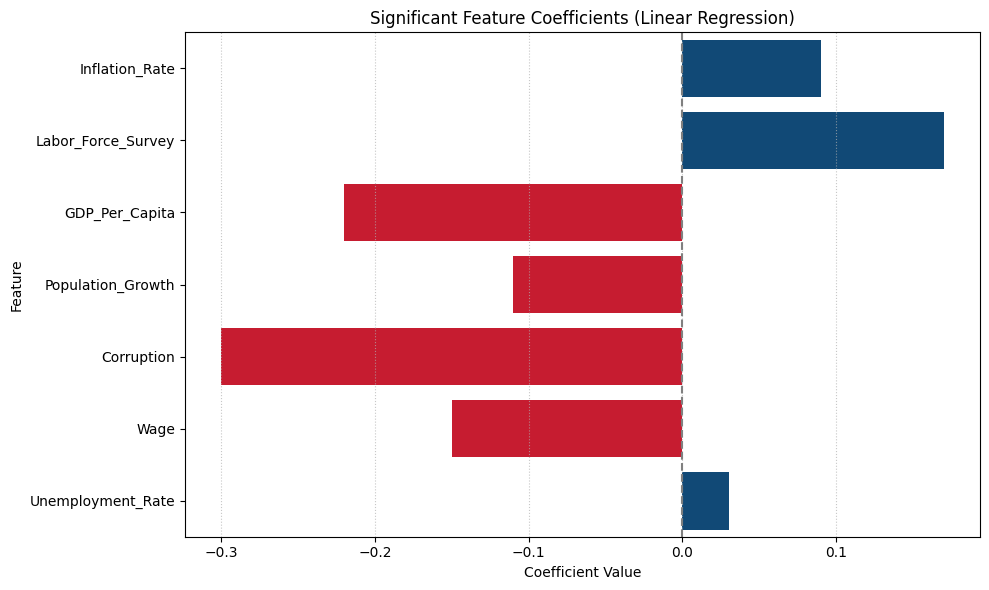

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define significant features and their coefficients
features = {
    'Inflation_Rate' : 0.09,
    'Labor_Force_Survey': 0.17,
    'GDP_Per_Capita': -0.22,
    'Population_Growth': -0.11,
    'Corruption': -0.3,
    'Wage': -0.15,
    "Unemployment_Rate": 0.03
}

# Create DataFrame for plotting
coef_df = pd.DataFrame(list(features.items()), columns=['Feature', 'Coefficient'])
coef_df['Color'] = coef_df['Coefficient'].apply(lambda x: '#E2001A' if x < 0 else '#004B87')

# Plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette=coef_df['Color'].tolist())
plt.axvline(x=0, color='gray', linestyle='--')
plt.grid(axis='x', linestyle=':', alpha=0.7)
plt.title('Significant Feature Coefficients (Linear Regression)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()

<ipython-input-12-5518c0b55ae0>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette=coef_df['Color'].tolist(),


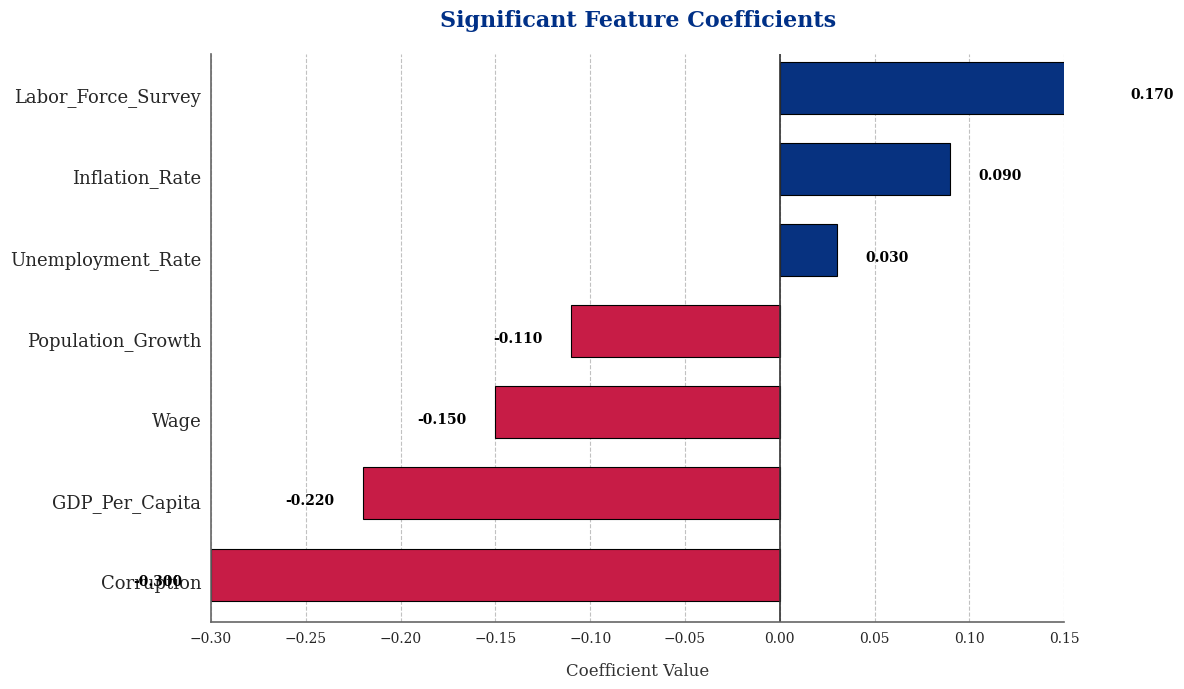

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define significant features and their coefficients
features = {
    'Inflation_Rate' : 0.09,
    'Labor_Force_Survey': 0.17,
    'GDP_Per_Capita': -0.22,
    'Population_Growth': -0.11,
    'Corruption': -0.3,
    'Wage': -0.15,
    "Unemployment_Rate": 0.03
}

# Create DataFrame for plotting
coef_df = pd.DataFrame(list(features.items()), columns=['Feature', 'Coefficient'])
# Match colors to SMC logo
coef_df['Color'] = coef_df['Coefficient'].apply(lambda x: '#003087' if x >= 0 else '#D11241')

# Sort DataFrame by Coefficient in descending order
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Set style and font
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 13

# Plot
plt.figure(figsize=(12, 7), facecolor='white')
barplot = sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette=coef_df['Color'].tolist(),
                      edgecolor='black', linewidth=0.8, saturation=0.9)

# Add coefficient values at the end of each bar
for i, v in enumerate(coef_df['Coefficient']):
    offset = 0.015 if v >= 0 else -0.015
    barplot.text(v + offset, i, f'{v:.3f}', va='center',
                 ha='left' if v >= 0 else 'right', color='black', fontsize=10, fontweight='bold')

# Customize plot
plt.axvline(x=0, color='#333333', linestyle='-', linewidth=1.2)
plt.title('Significant Feature Coefficients', pad=20, fontweight='bold', color='#003087')
plt.xlabel('Coefficient Value', labelpad=12, color='#333333')
plt.ylabel('')  # Remove y-axis title

# Set x-axis limits to reduce crowding
plt.xlim(-0.30, 0.15)

# Adjust grid and background
plt.grid(axis='x', linestyle='--', alpha=0.4, color='#666666')
barplot.set_facecolor('white')
barplot.spines['top'].set_visible(False)
barplot.spines['right'].set_visible(False)
barplot.spines['left'].set_color('#666666')
barplot.spines['left'].set_linewidth(1.2)
barplot.spines['bottom'].set_color('#666666')
barplot.spines['bottom'].set_linewidth(1.2)

# Adjust bar width for better spacing
for patch in barplot.patches:
    current_width = patch.get_height()
    patch.set_height(current_width * 0.8)

plt.tight_layout()
plt.savefig('feature_coefficients_enhanced.png')

Available countries: ['AUS', 'AUT', 'BEL', 'CAN', 'CHE', 'DEU', 'DNK', 'FIN', 'FRA', 'GBR', 'IRL', 'ISL', 'JPN', 'LUX', 'NLD', 'NOR', 'NZL', 'SWE', 'USA']
Please enter the country code to visualize (e.g., USA, AUS, CAN): DNK


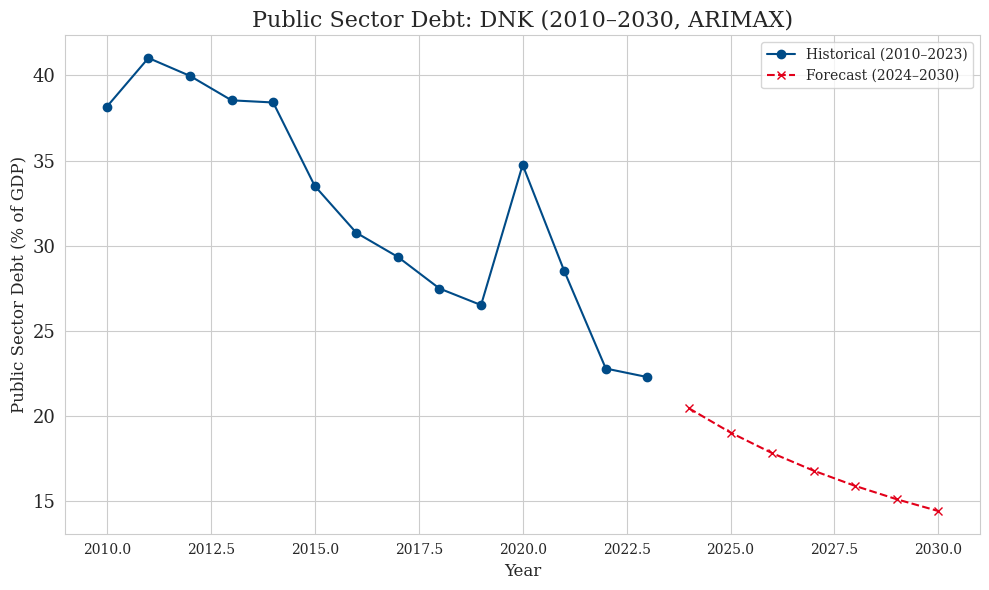

In [ ]:
import matplotlib.pyplot as plt
import os

# --- Step 1: Prompt User for Country Selection ---
available_countries = sorted(analysis_df['CCode'].unique())
print(f"Available countries: {available_countries}")

selected_country = input("Please enter the country code to visualize (e.g., USA, AUS, CAN): ").strip().upper()
while selected_country not in available_countries:
    print(f"Error: '{selected_country}' is not in the available countries list: {available_countries}")
    selected_country = input("Please enter a valid country code: ").strip().upper()

# --- Step 2: Prepare Data for Selected Country ---
country_df = analysis_df[analysis_df['CCode'] == selected_country].sort_values('Year')
historical_years = country_df['Year']
historical_debt = country_df['Public_Sector_Debt']

forecast_country = forecast_df[forecast_df['CCode'] == selected_country].sort_values('Year')
if forecast_country.empty:
    print(f"Warning: No forecast data available for {selected_country}. Plotting historical data only.")
    forecast_years = []
    forecast_values = []
else:
    forecast_years = forecast_country['Year']
    forecast_values = forecast_country['Public_Sector_Debt_Forecast']

# --- Step 3: Create Time Series Plot ---
plt.figure(figsize=(10, 6))

# Plot historical in dark blue
plt.plot(historical_years, historical_debt, label='Historical (2010–2023)', color='#004B87', marker='o')

# Plot forecast in red
if not forecast_country.empty:
    plt.plot(forecast_years, forecast_values, label='Forecast (2024–2030)', color='#E2001A', linestyle='--', marker='x')

plt.title(f'Public Sector Debt: {selected_country} (2010–2030, ARIMAX)')
plt.xlabel('Year')
plt.ylabel('Public Sector Debt (% of GDP)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


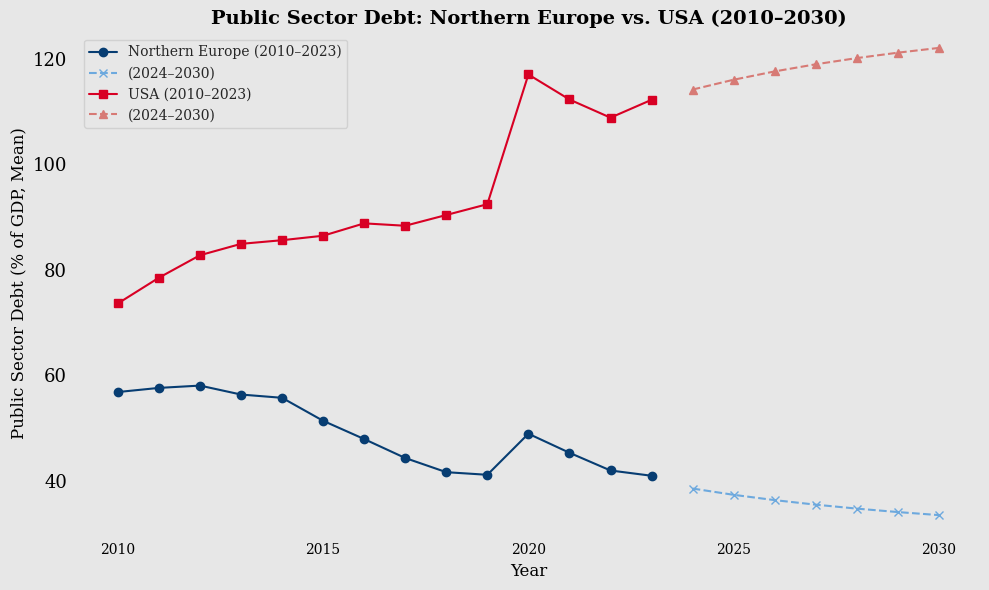

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Step 1: Define Groups ---
northern_europe = ['DNK', 'FIN', 'ISL', 'NOR', 'SWE', 'EST', 'LVA', 'LTU']
usa_code = 'USA'

# Color scheme
color_ne_hist = '#073d72'   # Northern Europe historical (dark blue)
color_ne_fore = '#6da9de'   # Northern Europe forecast (light blue)
color_usa_hist = '#d80024'  # USA historical (dark red)
color_usa_fore = '#d77a75'  # USA forecast (light red)

# --- Step 2: Filter Available Countries ---
valid_ne_countries = [c for c in northern_europe if c in analysis_df['CCode'].unique()]

# --- Step 3: Aggregate Historical Data ---
hist_ne = analysis_df[analysis_df['CCode'].isin(valid_ne_countries)]
hist_ne_agg = hist_ne.groupby('Year')['Public_Sector_Debt'].mean().reset_index()

hist_usa = analysis_df[analysis_df['CCode'] == usa_code]

# --- Step 4: Aggregate Forecast Data ---
forecast_ne = forecast_df[forecast_df['CCode'].isin(valid_ne_countries)]
forecast_ne_agg = forecast_ne.groupby('Year')['Public_Sector_Debt_Forecast'].mean().reset_index()

forecast_usa = forecast_df[forecast_df['CCode'] == usa_code]

# --- Step 5: Plot ---
plt.figure(figsize=(10, 6))
plt.gca().set_facecolor('#e7e7e7')         # Set plot area background
plt.gcf().patch.set_facecolor('#e7e7e7')   # Set outer figure background

# Northern Europe
plt.plot(hist_ne_agg['Year'], hist_ne_agg['Public_Sector_Debt'],
         label='Northern Europe (2010–2023)', color=color_ne_hist, marker='o')
if not forecast_ne_agg.empty:
    plt.plot(forecast_ne_agg['Year'], forecast_ne_agg['Public_Sector_Debt_Forecast'],
             label='(2024–2030)', color=color_ne_fore, linestyle='--', marker='x')

# USA
plt.plot(hist_usa['Year'], hist_usa['Public_Sector_Debt'],
         label='USA (2010–2023)', color=color_usa_hist, marker='s')
if not forecast_usa.empty:
    plt.plot(forecast_usa['Year'], forecast_usa['Public_Sector_Debt_Forecast'],
             label='(2024–2030)', color=color_usa_fore, linestyle='--', marker='^')

# --- Step 6: Style ---
plt.title('Public Sector Debt: Northern Europe vs. USA (2010–2030)', fontsize=14, weight='bold', color='black')
plt.xlabel('Year', fontsize=12, color='black')
plt.ylabel('Public Sector Debt (% of GDP, Mean)', fontsize=12, color='black')
plt.xticks(ticks=range(2010, 2031, 5), color='black')
plt.yticks(color='black')

# Remove gridlines and all spines
plt.grid(False)
for spine in ['top', 'right', 'left', 'bottom']:
    plt.gca().spines[spine].set_visible(False)

# Set legend background
legend = plt.legend()
legend.get_frame().set_facecolor('#e7e7e7')

plt.ylim(30, 125)
plt.tight_layout()
plt.show()

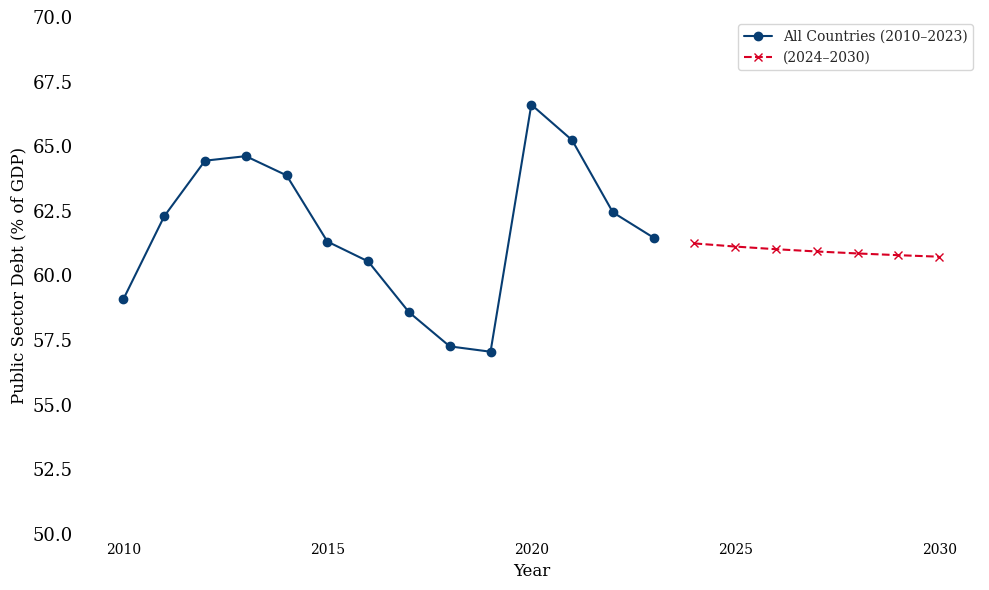

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Step 1: Set Colors ---
color_all_hist = '#073d72'  # Dark blue for historical
color_all_fore = '#d80024'  # Red for forecast

# --- Step 2: Average Historical Data Across All Countries ---
hist_all = analysis_df.groupby('Year')['Public_Sector_Debt'].mean().reset_index()

# --- Step 3: Average Forecast Data Across All Countries ---
forecast_all = forecast_df.groupby('Year')['Public_Sector_Debt_Forecast'].mean().reset_index()

# --- Step 4: Plot ---
plt.figure(figsize=(10, 6))

# Historical average line
plt.plot(hist_all['Year'], hist_all['Public_Sector_Debt'],
         label='All Countries (2010–2023)', color=color_all_hist, marker='o')

# Forecast average line
if not forecast_all.empty:
    plt.plot(forecast_all['Year'], forecast_all['Public_Sector_Debt_Forecast'],
             label='(2024–2030)', color=color_all_fore, linestyle='--', marker='x')

# Set x-axis ticks every 5 years
plt.xticks(ticks=range(2010, 2031, 5), color='black')

# --- Step 5: Style ---
# plt.title('Average Public Sector Debt Across All Selected Countries (2010–2030)',
          # fontsize=14, weight='bold', color='black')
plt.xlabel('Year', fontsize=12, color='black')
plt.ylabel('Public Sector Debt (% of GDP)', fontsize=12, color='black')
plt.yticks(color='black')

# Remove grid and spines
plt.grid(False)
for spine in ['top', 'right', 'left', 'bottom']:
    plt.gca().spines[spine].set_visible(False)

plt.legend()
plt.ylim(50, 70)
plt.tight_layout()
plt.show()



Scoring results saved to /content/drive/MyDrive/Capstone Data/Final Data/debt_risk_scores_2023_2030.csv


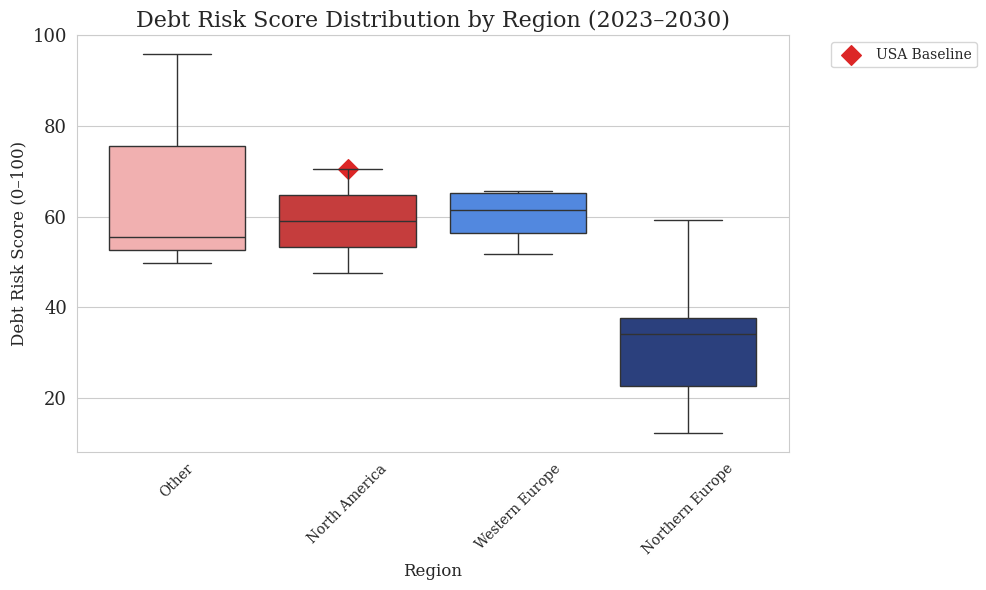

<ipython-input-16-b8119ceb427e>:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='CCode', y='Score', data=scoring_df, palette=colors)


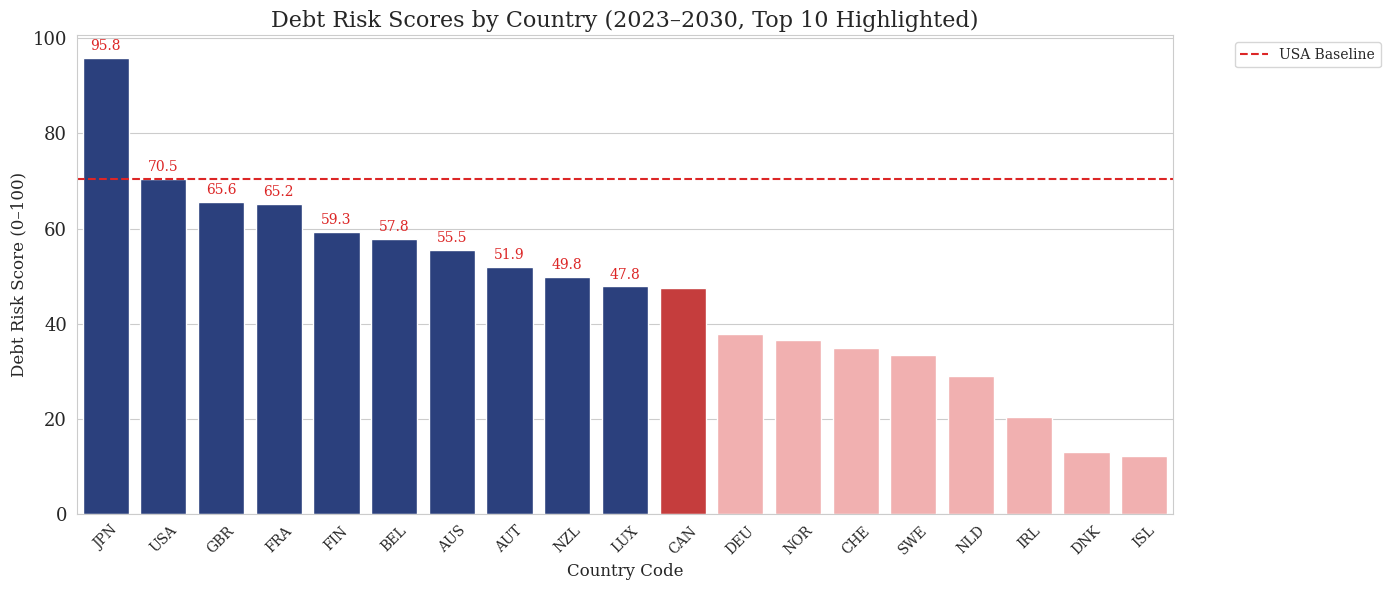

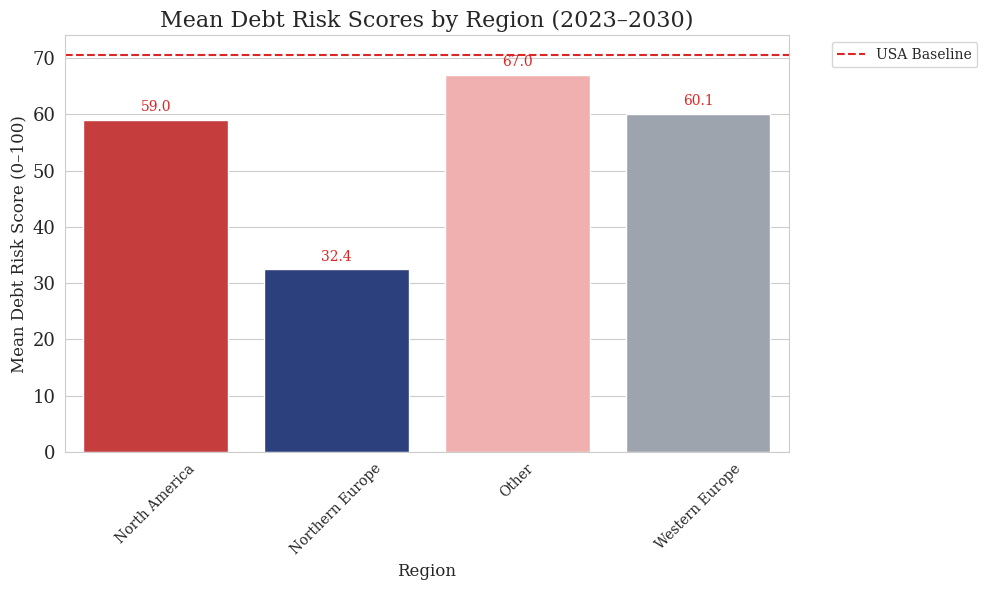


Top 10 Countries Summary (2023–2030):
   CCode  Score  Debt_2023  Debt_2030  Percent_Change_2023_2030
10   JPN  95.82     205.61     226.29                     10.05
17   USA  70.49     112.26     122.10                      8.77
16   GBR  65.57     100.53     106.89                      6.33
6    FRA  65.16      92.30     100.24                      8.59
5    FIN  59.25      75.83      80.75                      6.50
2    BEL  57.79      87.23      87.87                      0.74
0    AUS  55.48      34.83      40.22                     15.48
1    AUT  51.86      58.95      60.49                      2.62
12   NZL  49.77      45.77      47.77                      4.36
11   LUX  47.82      20.81      22.95                     10.28

Regional Summary:
            Region  Score  Debt_2023  Debt_2030  Num_Countries
0    North America  58.99      81.09      86.00              2
1  Northern Europe  32.44      38.03      31.19             10
2            Other  67.02      95.41     104.76  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Step 1: Extract Current Debt Levels (2023) ---
# Filter for 2023 data
debt_2023 = analysis_df[analysis_df['Year'] == 2023][['CCode', 'Public_Sector_Debt']].copy()
debt_2023 = debt_2023.rename(columns={'Public_Sector_Debt': 'Debt_2023'})

# Check for missing 2023 data
missing_2023 = set(analysis_df['CCode'].unique()) - set(debt_2023['CCode'])
if missing_2023:
    print(f"Warning: No 2023 data for countries: {missing_2023}")

# --- Step 2: Extract 2030 Forecasted Debt Levels ---
# Filter for 2030 forecasts
debt_2030 = forecast_df[forecast_df['Year'] == 2030][['CCode', 'Public_Sector_Debt_Forecast']].copy()
debt_2030 = debt_2030.rename(columns={'Public_Sector_Debt_Forecast': 'Debt_2030'})

# Check for missing 2030 forecasts
missing_2030 = set(analysis_df['CCode'].unique()) - set(debt_2030['CCode'])
if missing_2030:
    print(f"Warning: No 2030 forecast data for countries: {missing_2030}")

# --- Step 3: Merge and Calculate Percent Change ---
# Merge 2023 and 2030 data
scoring_df = debt_2023.merge(debt_2030, on='CCode', how='inner')
if scoring_df.empty:
    raise ValueError("No countries with both 2023 and 2030 data to score.")

# Calculate percent change from 2023 to 2030
scoring_df['Percent_Change_2023_2030'] = (scoring_df['Debt_2030'] - scoring_df['Debt_2023']) / scoring_df['Debt_2023'] * 100

# --- Step 4: Normalize Metrics and Compute Composite Score ---
# Normalize Debt_2023 (higher debt = higher score)
debt_min = scoring_df['Debt_2023'].min()
debt_max = scoring_df['Debt_2023'].max()
scoring_df['Normalized_Debt_2023'] = (scoring_df['Debt_2023'] - debt_min) / (debt_max - debt_min)

# Normalize Percent_Change (higher increase = higher score)
percent_min = scoring_df['Percent_Change_2023_2030'].min()
percent_max = scoring_df['Percent_Change_2023_2030'].max()
scoring_df['Normalized_Percent_Change'] = (scoring_df['Percent_Change_2023_2030'] - percent_min) / (percent_max - percent_min)

# Compute composite score (0–1 scale, then scale to 0–100)
w1 = 0.5  # Weight for current debt
w2 = 0.5  # Weight for percent change
scoring_df['Score'] = (w1 * scoring_df['Normalized_Debt_2023'] + w2 * scoring_df['Normalized_Percent_Change']) * 100

# --- Step 5: Assign Regions ---
# Define regions based on CCode, with IRL and CHE in Northern Europe, and Eastern Europe included
regions = {
    'Northern Europe': ['DNK', 'FIN', 'ISL', 'NOR', 'SWE', 'NLD', 'DEU', 'LUX', 'IRL', 'CHE'],
    'Eastern Europe': [ 'LTU', 'EST', 'POL', 'CZE', 'SVK', 'HUN'],
    'Western Europe': ['AUT', 'BEL', 'FRA', 'GBR'],
    'North America': ['CAN', 'USA'],
    'Other': ['AUS', 'ITA', 'JPN', 'KOR', 'NZL']
}
scoring_df['Region'] = scoring_df['CCode'].apply(lambda x: next((k for k, v in regions.items() if x in v), 'Other'))

# Sort by score
score_columns = ['CCode', 'Debt_2023', 'Debt_2030', 'Percent_Change_2023_2030', 'Score', 'Region']
scoring_df = scoring_df[score_columns].sort_values('Score', ascending=False)

# --- Step 6: Save Scoring Results ---
score_path = os.path.join(data_folder, 'debt_risk_scores_2023_2030.csv')
scoring_df.to_csv(score_path, index=False)
print(f"\nScoring results saved to {score_path}")

# --- Step 7: Visualizations with Updated Color Theme ---
# Define color theme
dark_blue = '#1E3A8A'  # Northern Europe
lighter_blue = '#3B82F6'  # Eastern Europe
gray = '#9CA3AF'  # Western Europe
red = '#DC2626'  # North America, USA baseline
light_red = '#FCA5A5'  # Other

# Check if Eastern Europe is present
if 'Eastern Europe' not in scoring_df['Region'].values:
    print("Warning: No Eastern Europe countries in scoring data")

# 1. Box Plot: Score Distribution by Region
plt.figure(figsize=(10, 6))
sns.boxplot(x='Region', y='Score', data=scoring_df, hue='Region', palette={
    'Northern Europe': dark_blue,
    'Eastern Europe': lighter_blue,
    'Western Europe': lighter_blue,
    'North America': red,
    'Other': light_red
})
plt.scatter(x=[scoring_df[scoring_df['CCode'] == 'USA']['Region'].values[0]],
            y=[scoring_df[scoring_df['CCode'] == 'USA']['Score'].values[0]],
            color=red, marker='D', s=100, label='USA Baseline')
plt.title('Debt Risk Score Distribution by Region (2023–2030)')
plt.xlabel('Region')
plt.ylabel('Debt Risk Score (0–100)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(data_folder, 'debt_risk_scores_box.png'), bbox_inches='tight')
plt.show()

# 2. Bar Plot: Top 10 Countries vs. Others
top_10 = scoring_df.head(10)
plt.figure(figsize=(14, 6))
colors = []
for ccode, region in zip(scoring_df['CCode'], scoring_df['Region']):
    if ccode in top_10['CCode'].values:
        colors.append(dark_blue)  # Top 10 (Northern Europe)
    elif region == 'Eastern Europe':
        colors.append(lighter_blue)
    elif region == 'Western Europe':
        colors.append(gray)
    elif region == 'North America':
        colors.append(red)
    else:
        colors.append(light_red)
sns.barplot(x='CCode', y='Score', data=scoring_df, palette=colors)
plt.axhline(y=scoring_df[scoring_df['CCode'] == 'USA']['Score'].values[0], color=red, linestyle='--', label='USA Baseline')
for i, (ccode, score) in enumerate(zip(top_10['CCode'], top_10['Score'])):
    plt.text(i, score + 1, f'{score:.1f}', ha='center', va='bottom', fontsize=10, color=red)
plt.title('Debt Risk Scores by Country (2023–2030, Top 10 Highlighted)')
plt.xlabel('Country Code')
plt.ylabel('Debt Risk Score (0–100)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(data_folder, 'top_10_countries_debt_scores.png'), bbox_inches='tight')
plt.show()

# 3. Bar Plot: Mean Scores by Region
region_scores = scoring_df.groupby('Region').agg({'Score': 'mean', 'CCode': 'count'}).reset_index()
region_scores = region_scores.rename(columns={'CCode': 'Num_Countries'})
plt.figure(figsize=(10, 6))
sns.barplot(x='Region', y='Score', data=region_scores, hue='Region', palette={
    'Northern Europe': dark_blue,
    'Eastern Europe': lighter_blue,
    'Western Europe': gray,
    'North America': red,
    'Other': light_red
})
plt.axhline(y=scoring_df[scoring_df['CCode'] == 'USA']['Score'].values[0], color=red, linestyle='--', label='USA Baseline')
for i, score in enumerate(region_scores['Score']):
    plt.text(i, score + 1, f'{score:.1f}', ha='center', va='bottom', color=red)
plt.title('Mean Debt Risk Scores by Region (2023–2030)')
plt.xlabel('Region')
plt.ylabel('Mean Debt Risk Score (0–100)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(data_folder, 'mean_debt_risk_scores_by_region.png'), bbox_inches='tight')
plt.show()

# --- Step 8: Summary Table ---
# Summary for top 10 countries
top_10_summary = scoring_df[scoring_df['CCode'].isin(top_10['CCode'])][['CCode', 'Score', 'Debt_2023', 'Debt_2030', 'Percent_Change_2023_2030']]
print("\nTop 10 Countries Summary (2023–2030):")
print(top_10_summary.round(2))

# Regional summary
region_summary = scoring_df.groupby('Region').agg({
    'Score': 'mean',
    'Debt_2023': 'mean',
    'Debt_2030': 'mean',
    'CCode': 'count'
}).reset_index()
region_summary = region_summary.rename(columns={'CCode': 'Num_Countries'})
print("\nRegional Summary:")
print(region_summary.round(2))

<ipython-input-33-43dede51517b>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=ranking, palette=gradient_hex, ax=ax)


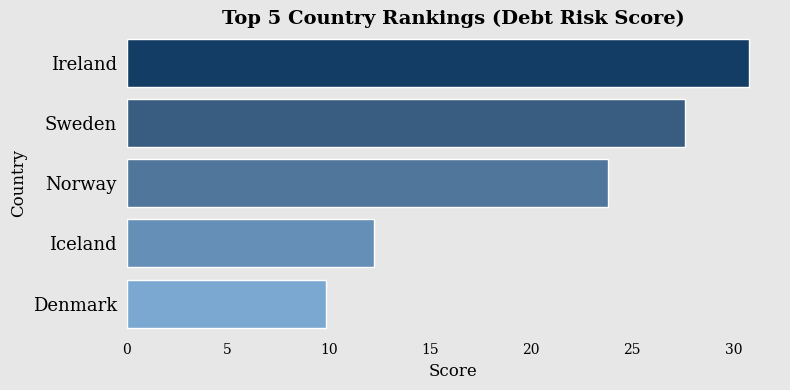

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Country ranking data (DNK is best → darkest)
ranking = ['Ireland', 'Sweden', 'Norway', 'Iceland', 'Denmark']
scores = [30.77, 27.62, 23.79, 12.25, 9.84]

# Custom dark-to-light blue gradient
gradient_hex = [
    "#6DA9DE",  # DNK - lightest
    "#5890C3",  # ISL
    "#4376A8",  # NOR
    "#2D5D8D",  # SWE
    "#073D72"   # IRL - darkest
]
# Reverse the palette to match ranking (DNK = top = darkest)
gradient_hex = gradient_hex[::-1]

# Set up the plot with background color
background_color = '#e7e7e7'
fig, ax = plt.subplots(figsize=(8, 4), facecolor=background_color)
ax.set_facecolor(background_color)

# Plot
sns.barplot(x=scores, y=ranking, palette=gradient_hex, ax=ax)

# Styling
ax.set_title('Top 5 Country Rankings (Debt Risk Score)', fontsize=14, weight='bold', color='black')
ax.set_xlabel('Score', color='black')
ax.set_ylabel('Country', color='black')
ax.tick_params(colors='black')

# Remove grid and axis lines
ax.grid(False)
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()


Index(['CCode', 'Debt_2023', 'Debt_2030', 'Percent_Change_2023_2030', 'Score',
       'Region'],
      dtype='object')


<ipython-input-27-4460d37c6730>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='CCode', y='Score', data=scoring_df, palette=colors)


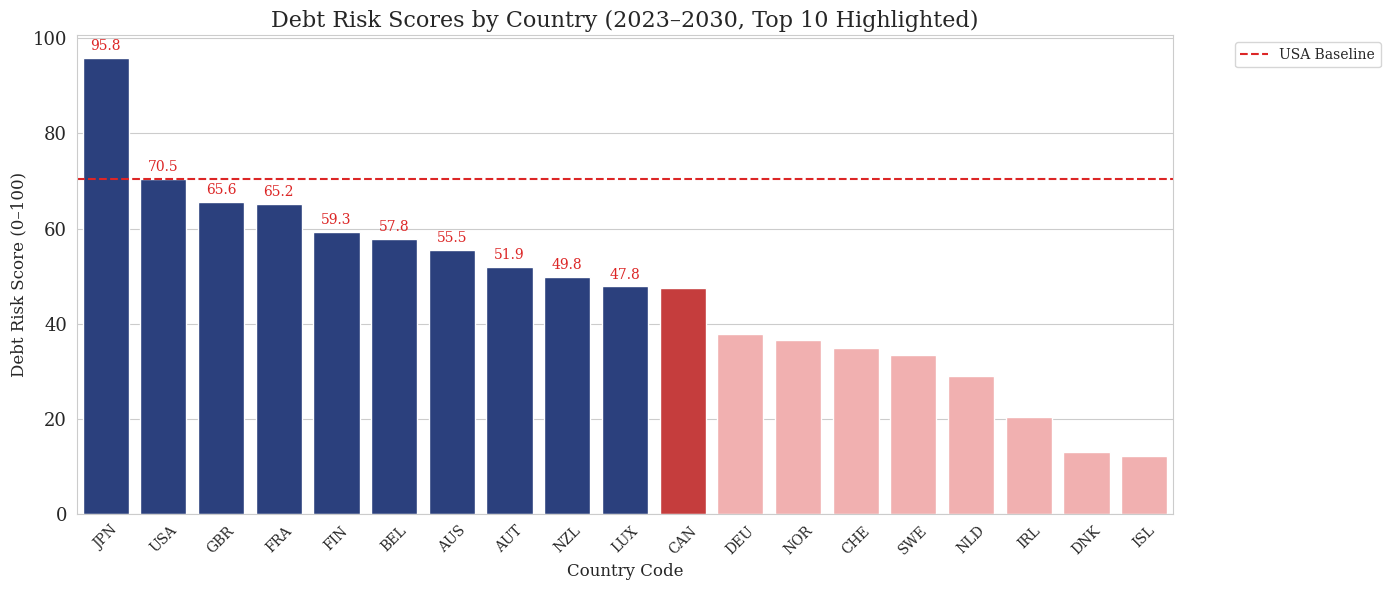

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `scoring_df` is already created and sorted
print(scoring_df.columns)
scoring_df = scoring_df.sort_values(by='Score', ascending=False).reset_index(drop=True)

# --- Bar Plot: Top 10 Countries vs. Others ---
top_10 = scoring_df.head(10)

plt.figure(figsize=(14, 6))

# Assign colors based on region and top 10 status
dark_blue = '#1E3A8A'
lighter_blue = '#3B82F6'
gray = '#9CA3AF'
red = '#DC2626'
light_red = '#FCA5A5'

colors = []
for ccode, region in zip(scoring_df['CCode'], scoring_df['Region']):
    if ccode in top_10['CCode'].values:
        colors.append(dark_blue)
    elif region == 'Eastern Europe':
        colors.append(lighter_blue)
    elif region == 'Western Europe':
        colors.append(gray)
    elif region == 'North America':
        colors.append(red)
    else:
        colors.append(light_red)

sns.barplot(x='CCode', y='Score', data=scoring_df, palette=colors)

# Draw USA baseline
plt.axhline(y=scoring_df[scoring_df['CCode'] == 'USA']['Score'].values[0],
            color=red, linestyle='--', label='USA Baseline')

# Add labels to top 10 bars
for i, (ccode, score) in enumerate(zip(top_10['CCode'], top_10['Score'])):
    plt.text(i, score + 1, f'{score:.1f}', ha='center', va='bottom', fontsize=10, color=red)

plt.title('Debt Risk Scores by Country (2023–2030, Top 10 Highlighted)')
plt.xlabel('Country Code')
plt.ylabel('Debt Risk Score (0–100)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


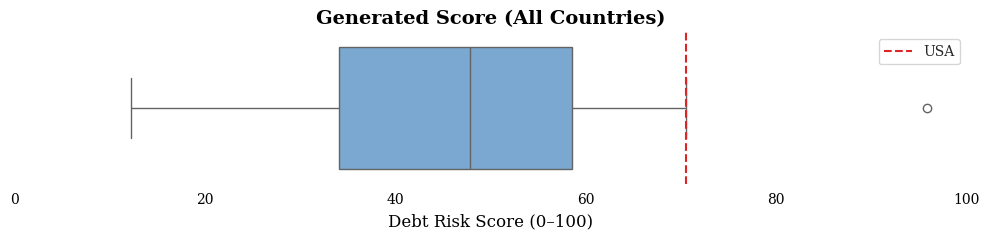

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 2.5))
sns.boxplot(x='Score', data=scoring_df, color='#6da9de')  # light blue

# Add USA baseline
usa_score = scoring_df[scoring_df['CCode'] == 'USA']['Score'].values[0]
plt.axvline(x=usa_score, color='#DC2626', linestyle='--', label='USA')

# Style
plt.title('Generated Score (All Countries)', fontsize=14, weight='bold', color='black')
plt.xlabel('Debt Risk Score (0–100)', color='black')
plt.yticks([])

# Force x-axis ticks from 0 to 100 in increments of 20
plt.xticks(ticks=range(0, 101, 20), color='black')

# Remove grid and all spines including x-axis line
plt.grid(False)
for spine in ['top', 'right', 'left', 'bottom']:
    plt.gca().spines[spine].set_visible(False)

# Legend
plt.legend()

plt.tight_layout()
plt.show()


<ipython-input-20-e701a2bff49c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Region', y='Score', data=region_scores, palette=color_map)


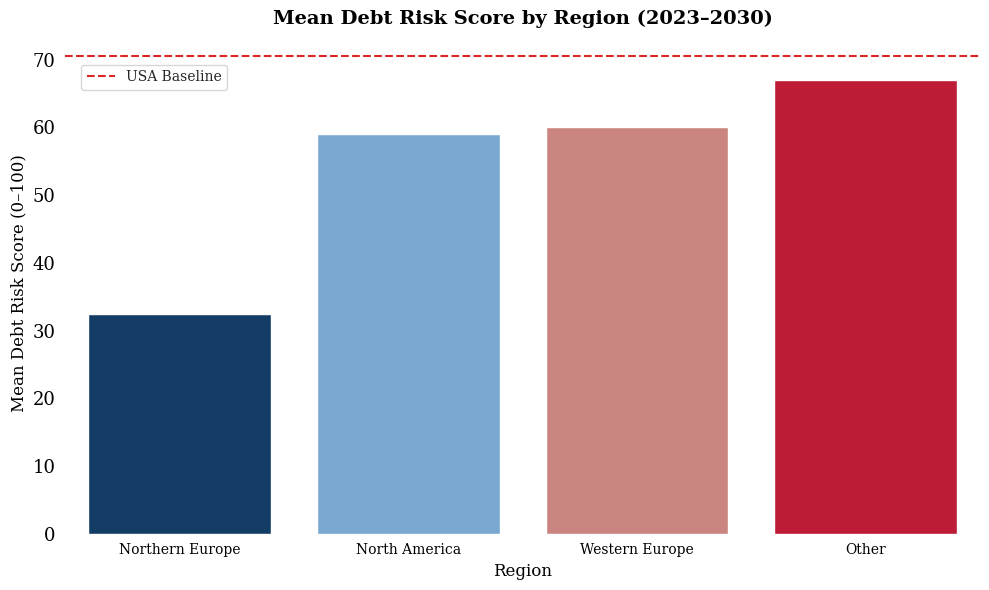

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group and sort
region_scores = scoring_df.groupby('Region').agg({'Score': 'mean'}).reset_index()
region_scores = region_scores.sort_values('Score', ascending=True)

# Color map
color_map = {
    'Northern Europe': '#073d72',
    'Eastern Europe': '#3B82F6',
    'Western Europe': '#d77a75',
    'North America': '#6da9de',
    'Other': '#d80024'
}

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Region', y='Score', data=region_scores, palette=color_map)

# Remove all axis lines (spines)
for spine in ['top', 'right', 'left', 'bottom']:
    plt.gca().spines[spine].set_visible(False)

# Remove grid
plt.grid(False)

# USA Baseline line
usa_score = scoring_df[scoring_df['CCode'] == 'USA']['Score'].values[0]
plt.axhline(y=usa_score, color='#DC2626', linestyle='--', label='USA Baseline')

# Bold black title
plt.title('Mean Debt Risk Score by Region (2023–2030)', fontsize=14, weight='bold', color='black')

# Axis labels in black
plt.xlabel('Region', color='black')
plt.ylabel('Mean Debt Risk Score (0–100)', color='black')

# Tick labels in black, no rotation
plt.xticks(rotation=0, color='black')
plt.yticks(color='black')

# Legend under baseline, left
plt.legend(loc='upper left', bbox_to_anchor=(0.01, 0.95))

plt.tight_layout()
plt.show()


<ipython-input-21-1d50dfc1cbd4>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='CCode', y='Score', data=top5_df, palette=get_custom_palette(top5_df['CCode']))


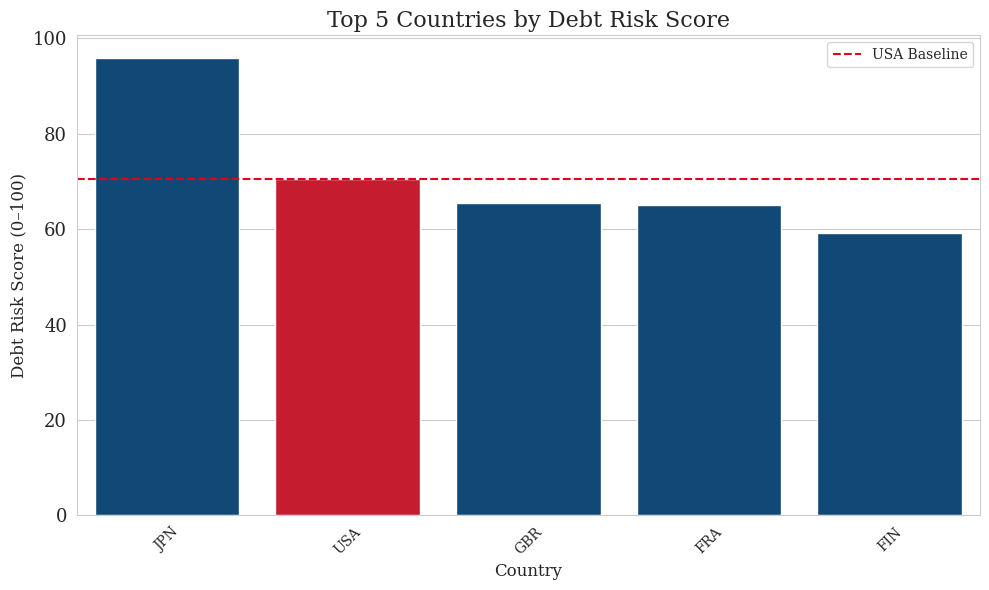

<ipython-input-21-1d50dfc1cbd4>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='CCode', y='Score', data=bottom5_df, palette=get_custom_palette(bottom5_df['CCode']))


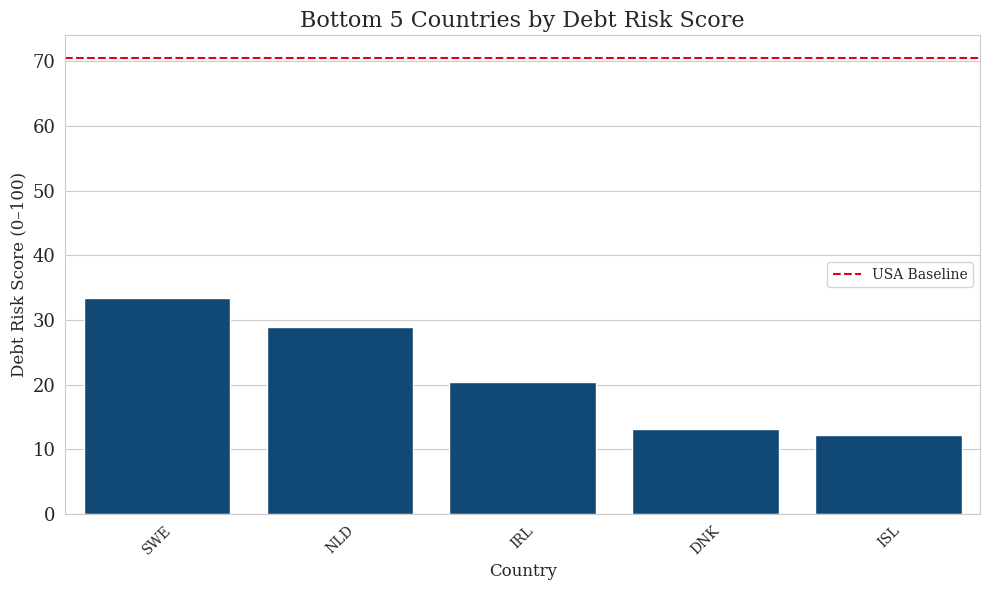

In [ ]:
# --- Custom Color Function ---
def get_custom_palette(ccodes, highlight='USA'):
    return ['#E2001A' if ccode == highlight else '#004B87' for ccode in ccodes]

# --- Top 5 Countries ---
top5_df = scoring_df.head(5)
plt.figure(figsize=(10, 6))
sns.barplot(x='CCode', y='Score', data=top5_df, palette=get_custom_palette(top5_df['CCode']))
plt.axhline(y=scoring_df[scoring_df['CCode'] == 'USA']['Score'].values[0],
            color='#E2001A', linestyle='--', label='USA Baseline')
plt.title('Top 5 Countries by Debt Risk Score')
plt.xlabel('Country')
plt.ylabel('Debt Risk Score (0–100)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# --- Bottom 5 Countries ---
bottom5_df = scoring_df.tail(5)
plt.figure(figsize=(10, 6))
sns.barplot(x='CCode', y='Score', data=bottom5_df, palette=get_custom_palette(bottom5_df['CCode']))
plt.axhline(y=scoring_df[scoring_df['CCode'] == 'USA']['Score'].values[0],
            color='#E2001A', linestyle='--', label='USA Baseline')
plt.title('Bottom 5 Countries by Debt Risk Score')
plt.xlabel('Country')
plt.ylabel('Debt Risk Score (0–100)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


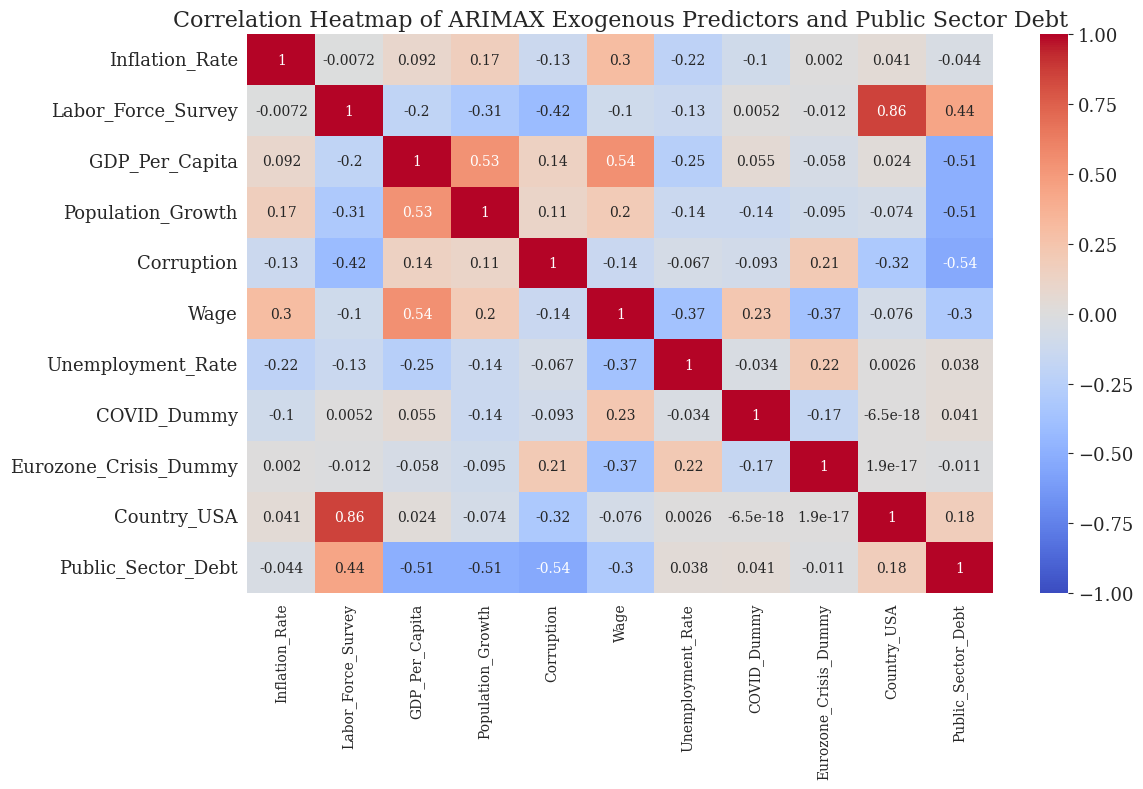

In [ ]:
# Visualizations
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

# Correlation Heatmap
if exog_features:
    plt.figure(figsize=(12, 8))
    # Include Public_Sector_Debt in the correlation matrix
    features_for_corr = exog_features + ['Public_Sector_Debt']
    corr_matrix = analysis_df[features_for_corr].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Heatmap of ARIMAX Exogenous Predictors and Public Sector Debt')
    plt.tight_layout()
    plt.show()
else:
    print("Warning: No exogenous features for correlation heatmap.")

In [ ]:
import os
import pandas as pd

# Define Northern Europe countries
northern_europe = ['DNK', 'FIN', 'ISL', 'NOR', 'SWE', 'EST', 'LVA', 'LTU']

# Filter the data for Northern Europe only
X_ne = X[analysis_df['CCode'].isin(northern_europe)]
scaler_means = X_ne.mean().values
scaler_stds = X_ne.std().values
feature_names = X_ne.columns.tolist()

print("\nCalculating effect of a 1% increase in Public_Sector_Debt on significant predictors and Unemployment_Rate (Northern Europe only):")

# Get significant results
significant_results = results_df[(results_df['P-value'] < 0.05) & (results_df['Variable'] != 'const')].copy()

# Add Unemployment_Rate if not already included
if 'Unemployment_Rate' not in significant_results['Variable'].values:
    unemployment_row = results_df[results_df['Variable'] == 'Unemployment_Rate']
    if not unemployment_row.empty:
        significant_results = pd.concat([significant_results, unemployment_row], ignore_index=True)
    else:
        print("Warning: Unemployment_Rate not found in results_df.")

# Initialize storage
effect_results = {
    'Variable': [],
    'Effect_on_Predictor': [],
    'Unit_Interpretation': [],
    'P-value': []
}

# Simulate 1% increase in log debt
delta_log_debt = 0.01

# Calculate effect for each significant predictor
for _, row in significant_results.iterrows():
    var = row['Variable']
    coef = row['Coefficient']
    p_value = row['P-value']

    try:
        idx = feature_names.index(var)
    except ValueError:
        print(f"Warning: {var} not found in filtered features. Skipping.")
        continue

    delta_scaled = delta_log_debt / coef if coef != 0 else 0
    delta_original = delta_scaled * scaler_stds[idx]

    # Unit interpretation
    if var in ['Inflation_Rate', 'Population_Growth', 'Unemployment_Rate']:
        unit = 'percentage points'
    elif var == 'GDP_Per_Capita':
        unit = 'USD'
    elif var == 'Wage':
        unit = 'USD/year'
    elif var == 'Corruption':
        unit = 'index points (0-100)'
    elif var == 'Labor_Force_Survey':
        unit = 'persons'
    else:
        unit = 'units'

    effect_results['Variable'].append(var)
    effect_results['Effect_on_Predictor'].append(delta_original)
    effect_results['P-value'].append(p_value)
    effect_results['Unit_Interpretation'].append(f"Change in {var} ({unit})")

# Convert to DataFrame and save
effect_df = pd.DataFrame(effect_results)
effect_path = os.path.join(data_folder, 'effect_1percent_debt_increase_NorthernEurope.csv')
effect_df.to_csv(effect_path, index=False)

print(f"\nEffect results saved to {effect_path}")
print(effect_df)



Calculating effect of a 1% increase in Public_Sector_Debt on significant predictors and Unemployment_Rate (Northern Europe only):

Effect results saved to /content/drive/MyDrive/Capstone Data/Final Data/effect_1percent_debt_increase_NorthernEurope.csv
             Variable  Effect_on_Predictor  \
0      Inflation_Rate             0.002975   
1  Labor_Force_Survey            97.002180   
2      GDP_Per_Capita          -715.082410   
3   Population_Growth            -0.053890   
4          Corruption            -0.166949   
5                Wage          -628.047096   
6         Country_USA            -0.000000   
7   Unemployment_Rate             0.762326   

                               Unit_Interpretation       P-value  
0     Change in Inflation_Rate (percentage points)  3.021396e-03  
1           Change in Labor_Force_Survey (persons)  5.263142e-03  
2                   Change in GDP_Per_Capita (USD)  1.372323e-09  
3  Change in Population_Growth (percentage points)  1.838465e-04